In [2146]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

class NN(object):
    def __init__(self, size_layers=[784, 16, 16, 10], datapath=None, modelpath=None):
        self.data = np.load(datapath)
        self.size_layers = size_layers
        
        # The cache would be used to store forward feed activations and preactivations values 
        self.cache = {
            'activations': [],
            'preactivations': []
        }
        
        # Data structure to hold the params of the model
        self.theta = {
            'b': [],
            'w': []
        }
        
        # Data structure to hold the gradients calculated during backprop
        self.grads = {
            'b': [],
            'w': []
        }

In [2147]:
def initialize_zero_weights(self):
    size_next_layers = self.size_layers.copy()
    size_next_layers.pop(0)
    
    for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
        self.theta['w'].append(np.zeros((size_next_layer, size_layer)))
        self.theta['b'].append(np.zeros((1, size_next_layer)))
        
        self.grads['w'].append(np.zeros((size_next_layer, size_layer)))
        self.grads['b'].append(np.zeros((1, size_next_layer)))

In [2148]:
def initialize_normal_weights(self):
    size_next_layers = self.size_layers.copy()
    size_next_layers.pop(0)

    for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
        self.theta['w'].append(np.random.normal(size=(size_next_layer, size_layer)))
        self.theta['b'].append(np.zeros((1, size_next_layer)))

        self.grads['w'].append(np.zeros((size_next_layer, size_layer)))
        self.grads['b'].append(np.zeros((1, size_next_layer)))

In [2149]:
def initialize_glorot_weights(self):
    size_next_layers = self.size_layers.copy()
    size_next_layers.pop(0)

    for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
        d_l = np.sqrt(6/(size_layer+size_next_layer))
        m_d_l = -1*d_l
        
        self.theta['w'].append(np.random.uniform(m_d_l, d_l, size=(size_next_layer, size_layer)))
        self.theta['b'].append(np.zeros((1, size_next_layer)))

        self.grads['w'].append(np.zeros((size_next_layer, size_layer)))
        self.grads['b'].append(np.zeros((1, size_next_layer)))

In [2150]:
def forward(self, X):
    '''
    Forward propagation
    params:
        X: N by k matrix
        where
            N: number of samples
            k: dimension of sample
    returns: output is a N by o matrix where o is the output dimension specified
    in mlp initialization
    '''
    n_layers = len(self.size_layers)
    input_layer = X
    
    # Adding input in activations needed for gradient descent
    self.cache['activations'] = []
    self.cache['preactivations'] = []
    
    self.cache['activations'].append(X)
    
    # Index stops before the last layer as we'd need to treat it differently
    for layer_idx in range(n_layers - 2):
        
        # Multiply the input by the weights
        pre_act_layer = np.matmul(input_layer,  self.theta['w'][layer_idx].transpose()) + self.theta['b'][layer_idx]
        # Apply activation function
        output_layer = activation(self, pre_act_layer)
        
        self.cache['preactivations'].append(pre_act_layer)
        self.cache['activations'].append(output_layer)
        
        input_layer = output_layer
    
    # Final layer with softmax activation
    # Multiply the input by the weights
    pre_act_layer = np.matmul(input_layer, self.theta['w'][-1].transpose()) + self.theta['b'][-1]
    # Apply activation function
    output_layer = softmax(self, pre_act_layer)

    self.cache['preactivations'].append(pre_act_layer)
    self.cache['activations'].append(output_layer)
    
    return output_layer

In [2151]:
y_h = forward(mlp_experience, x)
y_h

print(mlp_experience.cache['activations'])

[array([[1, 3, 6, 8],
       [2, 4, 7, 9]]), array([[ 6.02485442, 10.02790409],
       [ 7.12704429, 10.97948074]]), array([[1.],
       [1.]])]


In [2152]:
def activation(self, input):
    zero_aux = np.zeros(input.shape)
    meta_z = np.stack((input , zero_aux), axis = -1)
    
    return np.max(meta_z, axis = -1)

In [2153]:
def activation_prime(self, input):
    result = input.copy()
    result[result<=0] = 0
    result[result>0] = 1

    return result

In [2154]:
def softmax(self, input):
    '''
    params:
        input: N by k matrix
        where
            N: number of samples
            k: dimension of each sample
    returns: a N by k matrix representing the probability distribution 
        of each sample
    '''
    e_x = np.exp(input - np.max(input, axis=1, keepdims=1))
    return e_x / e_x.sum(axis=1, keepdims=1)

In [2155]:
def loss(self, predictions, targets):
    '''
    Takes a batch of predictions and gets the cross entropy
    params:
        predictions: N by k matrix
        where
            N: number of samples
            k: dimension of each sample
        targets: N by 1 matrix containing label of each one
        where 
            N: number of samples
    returns: a scalar which is the loss value            
    '''
    N = predictions.shape[0] # batch size
    k = predictions.shape[1] # numb of classes
    
    return -1*np.sum(np.multiply(np.eye(k)[targets][0], np.log10(predictions)))/N

In [2156]:
def loss_prime(self, predictions, targets):
    k = predictions.shape[1] # numb of classes
    N = predictions.shape[0]

    return np.sum(np.multiply(np.eye(k)[targets], np.eye(k)[targets] - predictions), axis=0, keepdims=1)/N

In [2157]:
def backward(self, Y):
    '''
    Backward propagation
    params:
        Y: N by 1 matrix
        where
            N: number of samples
            column: is the label of the samples
    '''
    n_layers = len(self.size_layers)
    N = Y.shape[0]
    
    delta = loss_prime(self, self.cache['activations'][-1], Y)
    
    self.grads['b'][-1] = delta
    self.grads['w'][-1] = np.dot(delta.transpose(), np.sum(self.cache['activations'][-2], axis=0, keepdims=1)/N)
    
    for l in range(2, n_layers):
        z = self.cache['preactivations'][-l]
        o = activation_prime(self, z)
        
        delta = np.multiply(np.dot(delta, self.theta['w'][-l+1]), np.sum(o, axis=0, keepdims=1)/N)
        
        self.grads['b'][-l] = delta
        self.grads['w'][-l] = np.dot(delta.transpose(), np.sum(self.cache['activations'][-l-1], axis=0, keepdims=1)/N)

In [2158]:
def update(self, eta, lmbda):
    n_layers = len(self.size_layers)
    
    for layer_idx in range(n_layers - 1):
        grad_w = self.grads['w'][layer_idx]
        grad_b = self.grads['b'][layer_idx]
        w = self.theta['w'][layer_idx]
        b = self.theta['b'][layer_idx]
        
        self.theta['w'][layer_idx] = w - eta*grad_w - lmbda*w
        self.theta['b'][layer_idx] = b - eta*grad_b - lmbda*b

In [2159]:
def create_mini_batches(self, dataset, batch_size):
        X, Y = dataset
        
        
        mini_batches = [
            (X[k:k+batch_size], Y[k:k+batch_size]) for k in range(0, len(X), batch_size)
        ]
        
        return mini_batches

In [2160]:
def calculate_accuracy(self, Y_h, Y):
    return 100*np.sum(np.argmax(Y_h, axis=1) == Y)/ Y_h.shape[0]

In [2161]:
last_batch = []
def train(self, eta, epoch=20, batch_size=1000, lmbda=0.5):
    losses = {
        'train': [],
        'validation': []
    }
    
    accuracies = {
        'train': [],
        'validation': []
    }
    
    for i in range(epoch):
        train_set, valid_set, test_set = self.data
        
        train_mini_batches = create_mini_batches(self, train_set, batch_size=batch_size)
        validate_mini_batches = create_mini_batches(self, valid_set, batch_size=batch_size)
        
        tmp_losses = {
            'train': [],
            'validation': []
        }
        
        tmp_accuracies = {
            'train': [],
            'validation': []
        }
        
        for X, Y in train_mini_batches:
            Y_h = forward(self, X)
            backward(self, Y)
            update(self, eta, lmbda)
            
            los = loss(self, Y_h, Y)
            acc = calculate_accuracy(self, Y_h, Y)
            
            tmp_losses['train'].append(los)
            tmp_accuracies['train'].append(acc)
            
        for X, Y in validate_mini_batches:
            Y_h = forward(self, X)
            
            los = loss(self, Y_h, Y)
            acc = calculate_accuracy(self, Y_h, Y)
            
            last_batch = [(X, Y, Y_h)]
            
            tmp_losses['validation'].append(los)
            tmp_accuracies['validation'].append(acc)
            
        losses['validation'].append(np.mean(tmp_losses['validation']))
        losses['train'].append(np.mean(tmp_losses['train']))
        
        accuracies['validation'].append(np.mean(tmp_accuracies['validation']))
        accuracies['train'].append(np.mean(tmp_accuracies['train']))
        
    return losses, accuracies

In [2162]:
def test(self):
    train_set, valid_set, test_set = self.data

    X, Y = test_set
    Y_h = forward(self, X)
    
    return np.sum(np.argmax(Y_h, axis=1) != Y)/ X.shape[0]

In [2163]:
def draw_plots(self, epoch, accuracies, losses):
    x = range(epoch)
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(x, accuracies['validation'], 'g-')
    ax2.plot(x, accuracies['train'], 'b-')

    ax1.set_xlabel('epochs')
    ax1.set_ylabel('validation accuracies', color='g')
    ax2.set_ylabel('train accuracies', color='b')
    plt.title('Accuracies')

    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(x, losses['validation'], 'g-')
    ax2.plot(x, losses['train'], 'b-')

    ax1.set_xlabel('epochs')
    ax1.set_ylabel('validation loss', color='g')
    ax2.set_ylabel('train loss', color='b')
    plt.title('Loss functions')

    plt.show()

## Initialization

Initializing weights to zero, with 0.5 as learning rate and no minibatch

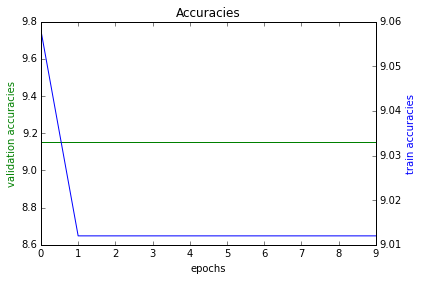

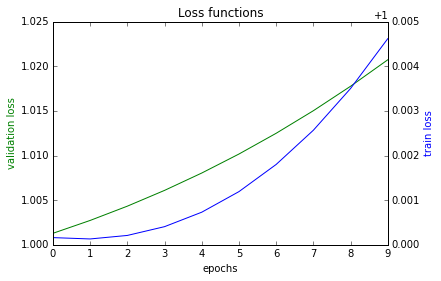

In [2165]:
datapath = 'data/mnist.pkl.npy'
modelpath = 'model/mlp.pkl.npy'

eta = 0.03
batch_size = 500
epoch = 10
lmbda = 0

mlp = NN(datapath=datapath, modelpath=modelpath, size_layers=[784, 10, 10, 10])

initialize_zero_weights(mlp)
losses, accuracies = train(mlp, eta, epoch=epoch, batch_size=batch_size, lmbda=lmbda)

draw_plots(mlp, epoch, accuracies, losses)

Initializing normally distributed weights

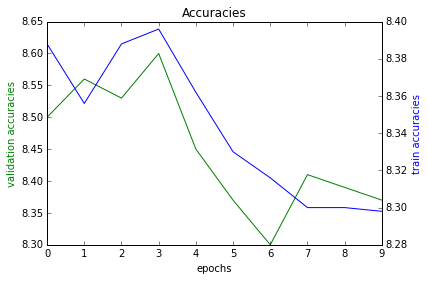

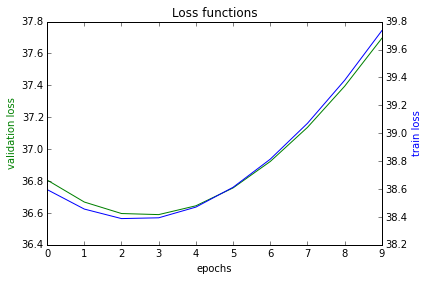

In [2074]:
datapath = 'data/mnist.pkl.npy'
modelpath = 'model/mlp.pkl.npy'

eta = 0.000045
batch_size = 500
epoch = 10
lmbda = 0

mlp = NN(datapath=datapath, modelpath=modelpath, size_layers=[784, 10, 10, 10])

initialize_normal_weights(mlp)
losses, accuracies = train(mlp, eta, epoch=epoch, batch_size=batch_size, lmbda=lmbda)

draw_plots(mlp, epoch, accuracies, losses)

Initializing with glorot distributed weights

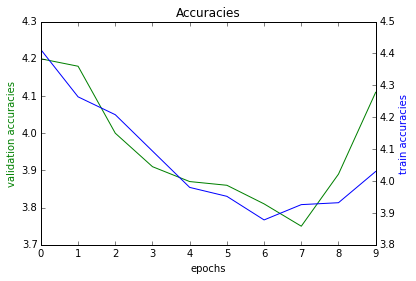

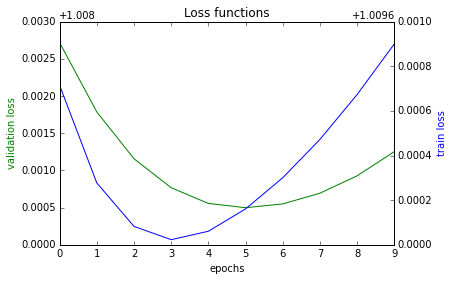

In [2100]:
datapath = 'data/mnist.pkl.npy'
modelpath = 'model/mlp.pkl.npy'

eta = 0.0003
batch_size = 500
epoch = 10
lmbda = 0

mlp = NN(datapath=datapath, modelpath=modelpath, size_layers=[784, 16, 16, 10])

initialize_glorot_weights(mlp)
losses, accuracies = train(mlp, eta, epoch=epoch, batch_size=batch_size, lmbda=lmbda)

draw_plots(mlp, epoch, accuracies, losses)

## Hyperparameter Search

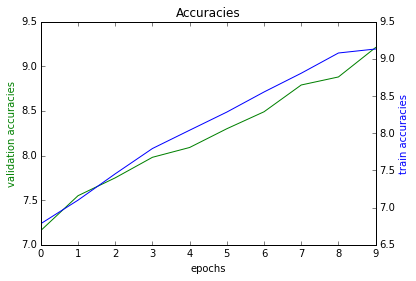

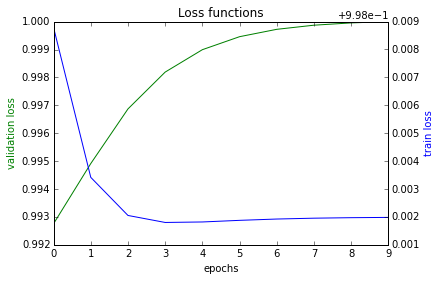

In [2076]:
datapath = 'data/mnist.pkl.npy'
modelpath = 'model/mlp.pkl.npy'

eta = 0.0003
batch_size = 500
epoch = 10
lmbda = 0.00200

mlp = NN(datapath=datapath, modelpath=modelpath, size_layers=[784, 16, 16, 10])

initialize_glorot_weights(mlp)
losses, accuracies = train(mlp, eta, epoch=epoch, batch_size=batch_size, lmbda=lmbda)

draw_plots(mlp, epoch, accuracies, losses)

## Validate Gradients using Finite Difference

In [2077]:
i = np.random.randint(0, 5, 5)
k = np.random.randint(1, 5, 5)

N = [k*10^i for i, k in zip(i, k)]
epsilons = [1/n for n in N]

mlp = NN(datapath=datapath, modelpath=modelpath, size_layers=[784, 16, 16, 10])

p = min(10, 16)

train_set, valid_set, test_set = mlp.data

X, Y = train_set

x = X[0]
y = Y[0]

results = []
for e, i, N, k in zip(epsilons, i, N, k):
    initialize_glorot_weights(mlp)
    mlp.theta['w'][1][:,p:] = 0
    old_w = mlp.theta['w'][1][:,i]
    
    mlp.theta['w'][1][:,i] = old_w + e
    Y_h = forward(mlp, x)
    l_los = loss(mlp, Y_h, y)
    
    mlp.theta['w'][1][:,i] = old_w - e
    Y_h = forward(mlp, x)
    r_los = loss(mlp, Y_h, y)
    
    delta_N_i = (l_los - r_los)/(2*e)
    results.append((e, i, k, N, delta_N_i))
    
print(results)

[(0.09090909090909091, 1, 1, 11, 0.0), (0.045454545454545456, 2, 2, 22, 0.0), (0.034482758620689655, 3, 3, 29, 0.0), (0.034482758620689655, 3, 3, 29, 0.0), (0.09090909090909091, 1, 1, 11, 0.0)]


In [2078]:
N = range(1, 50)
i = range(1, p)

max_diff = []

initialize_glorot_weights(mlp)

for n in N:
    e = 1/n
    grad_diff = []
    
    for _i in i:
        mlp.theta['w'][1][:,p:] = 0
        old_w = mlp.theta['w'][1][:,_i]

        mlp.theta['w'][1][:,_i] = old_w + e
        Y_h = forward(mlp, x)
        l_los = loss(mlp, Y_h, y)

        mlp.theta['w'][1][:,_i] = old_w - e
        Y_h = forward(mlp, x)
        r_los = loss(mlp, Y_h, y)

        delta_N_i = (l_los - r_los)/(2*e)
        
        mlp.theta['w'][1][:,_i] = old_w
        mlp.theta['w'][1][:,p:] = 0
        
        forward(mlp, x)
        backward(mlp, np.array([y]))
        real_grad = mlp.grads['w'][1]
        
        grad_diff.append(abs(delta_N_i - real_grad))
    
    max_diff.append(np.max(grad_diff))
    


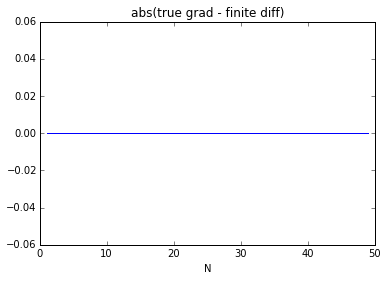

In [2079]:
plt.plot(N, max_diff)
plt.xlabel('N') 
plt.title('abs(true grad - finite diff)')
plt.show()

In [2186]:
x = np.array([
    [1, 3, 6, 8],
    [2, 4, 7, 9]
])
y = np.array([ 
    0, 
    1
])

mlp_experience = NN(datapath=datapath, modelpath=modelpath, size_layers=[4, 2, 2])
initialize_glorot_weights(mlp_experience)

In [2187]:
x = np.array([
    [1, 3, 6, 8],
    [2, 4, 7, 9]
])
y = np.array([ 
    0, 
    0
])
y_h = forward(mlp_experience, x)

In [2195]:
print(0.50037769*2 + 0.52710657*4 -0.47977167*7 + 0.84972747*9)
print(0.34739177*2 -0.78948968*4 +  0.61106684*7 +  0.1246129*9)

7.398327200000001
2.9358087999999998


In [2201]:
print(-0.06578369*7.39832714 - 0.56865302*2.93580881)
print(-0.70030729*7.39832714 + 0.13967644*2.93580881)

-2.156145805045453
-4.771039106845414


In [2189]:
mlp_experience.theta

{'b': [array([[0., 0.]]), array([[0., 0.]])],
 'w': [array([[ 0.50037769,  0.52710657, -0.47977167,  0.84972747],
         [ 0.34739177, -0.78948968,  0.61106684,  0.1246129 ]]),
  array([[-0.06578369, -0.56865302],
         [-0.70030729,  0.13967644]])]}

In [2193]:
mlp_experience.cache

{'activations': [array([[1, 3, 6, 8],
         [2, 4, 7, 9]]), array([[6.00088709, 2.64222698],
         [7.39832714, 2.93580881]]), array([[0.87392716, 0.12607284],
         [0.93181395, 0.06818605]])],
 'preactivations': [array([[6.00088709, 2.64222698],
         [7.39832714, 2.93580881]]), array([[-1.89727086, -3.83340808],
         [-2.15614582, -4.77103906]])]}

In [2191]:
backward(mlp_experience, y)
mlp_experience.grads

{'b': [array([[-0.00638953, -0.05523295]]), array([[0.09712944, 0.        ]])],
 'w': [array([[-0.0095843 , -0.02236337, -0.04153197, -0.05431103],
         [-0.08284943, -0.19331533, -0.35901418, -0.46948008]]),
  array([[0.6507291 , 0.27089575],
         [0.        , 0.        ]])]}

In [2185]:
loss(mlp_experience, y_h, y)

-0.0